### Preamble

In [1]:
import numpy as np
from scipy.optimize import leastsq
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Circle, Wedge

import sys
import os
parent_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)
from field_map_g4bl import readFieldMapData
from compute_multipole_components import fitMultipoles, computeField

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '../../..'))
sys.path.append(parent_dir)
from functions.set_plot_settings import setPlotSettings
setPlotSettings(font=True)

In [2]:
# Path to field map file:
file = 'fieldmap.txt'

# Animation directory:
ani_dir = 'animations/'

In [3]:
# Lattice parameters:
length = 300 # solenoid length (mm)
a = 420 # solenoid inner radius (mm)
b = 600 # solenoid outer radius (mm)

In [4]:
# Function to plot lattice:
def plotLattice():
    plt.axvspan(xmin=-length/2, xmax=length/2, color='lightgray', alpha=0.5)

In [5]:
# Function to plot solenoid cross-section:
def plotSolenoid(ax):
    circle_inner = plt.Circle([0,0], radius=a, fill=False, linestyle='-', color='white')
    ax.add_patch(circle_inner)
    circle_outer = plt.Circle([0,0], radius=b, fill=False, linestyle='-', color='white')
    ax.add_patch(circle_outer)
    fill = Wedge(center=(0, 0), r=b, theta1=0, theta2=360, width=b - a, color='white', label='Solenoid', alpha=0.8)
    ax.add_patch(fill)
    plt.legend(loc='upper right')

### Compute multipole components from G4bl fieldmap

In [6]:
data = readFieldMapData(file)

x = np.unique(data['x'].values)
y = np.unique(data['y'].values)
X, Y = np.meshgrid(x, y)

In [7]:
z_vals = np.arange(-700, 700, 1)
columns = ['z', 'n=1', 'n=2', 'n=3', 'n=4', 'n=5']
rows = []

for z in z_vals:

    data_slice = data[data['z'] == z]
    if data_slice.empty:
        continue

    Bx = data_slice.pivot_table(index='y', columns='x', values='Bx').values
    By = data_slice.pivot_table(index='y', columns='x', values='By').values

    max_order = 5
    coeffs = fitMultipoles(X, Y, Bx, By, max_order=max_order)
    coeffs_to_oct = [abs(coeffs[i]) for i in range(1, max_order+1)] # magnitude
    rows.append([z] + coeffs_to_oct)

df = pd.DataFrame(rows, columns=columns)

### Plot coefficients vs. z

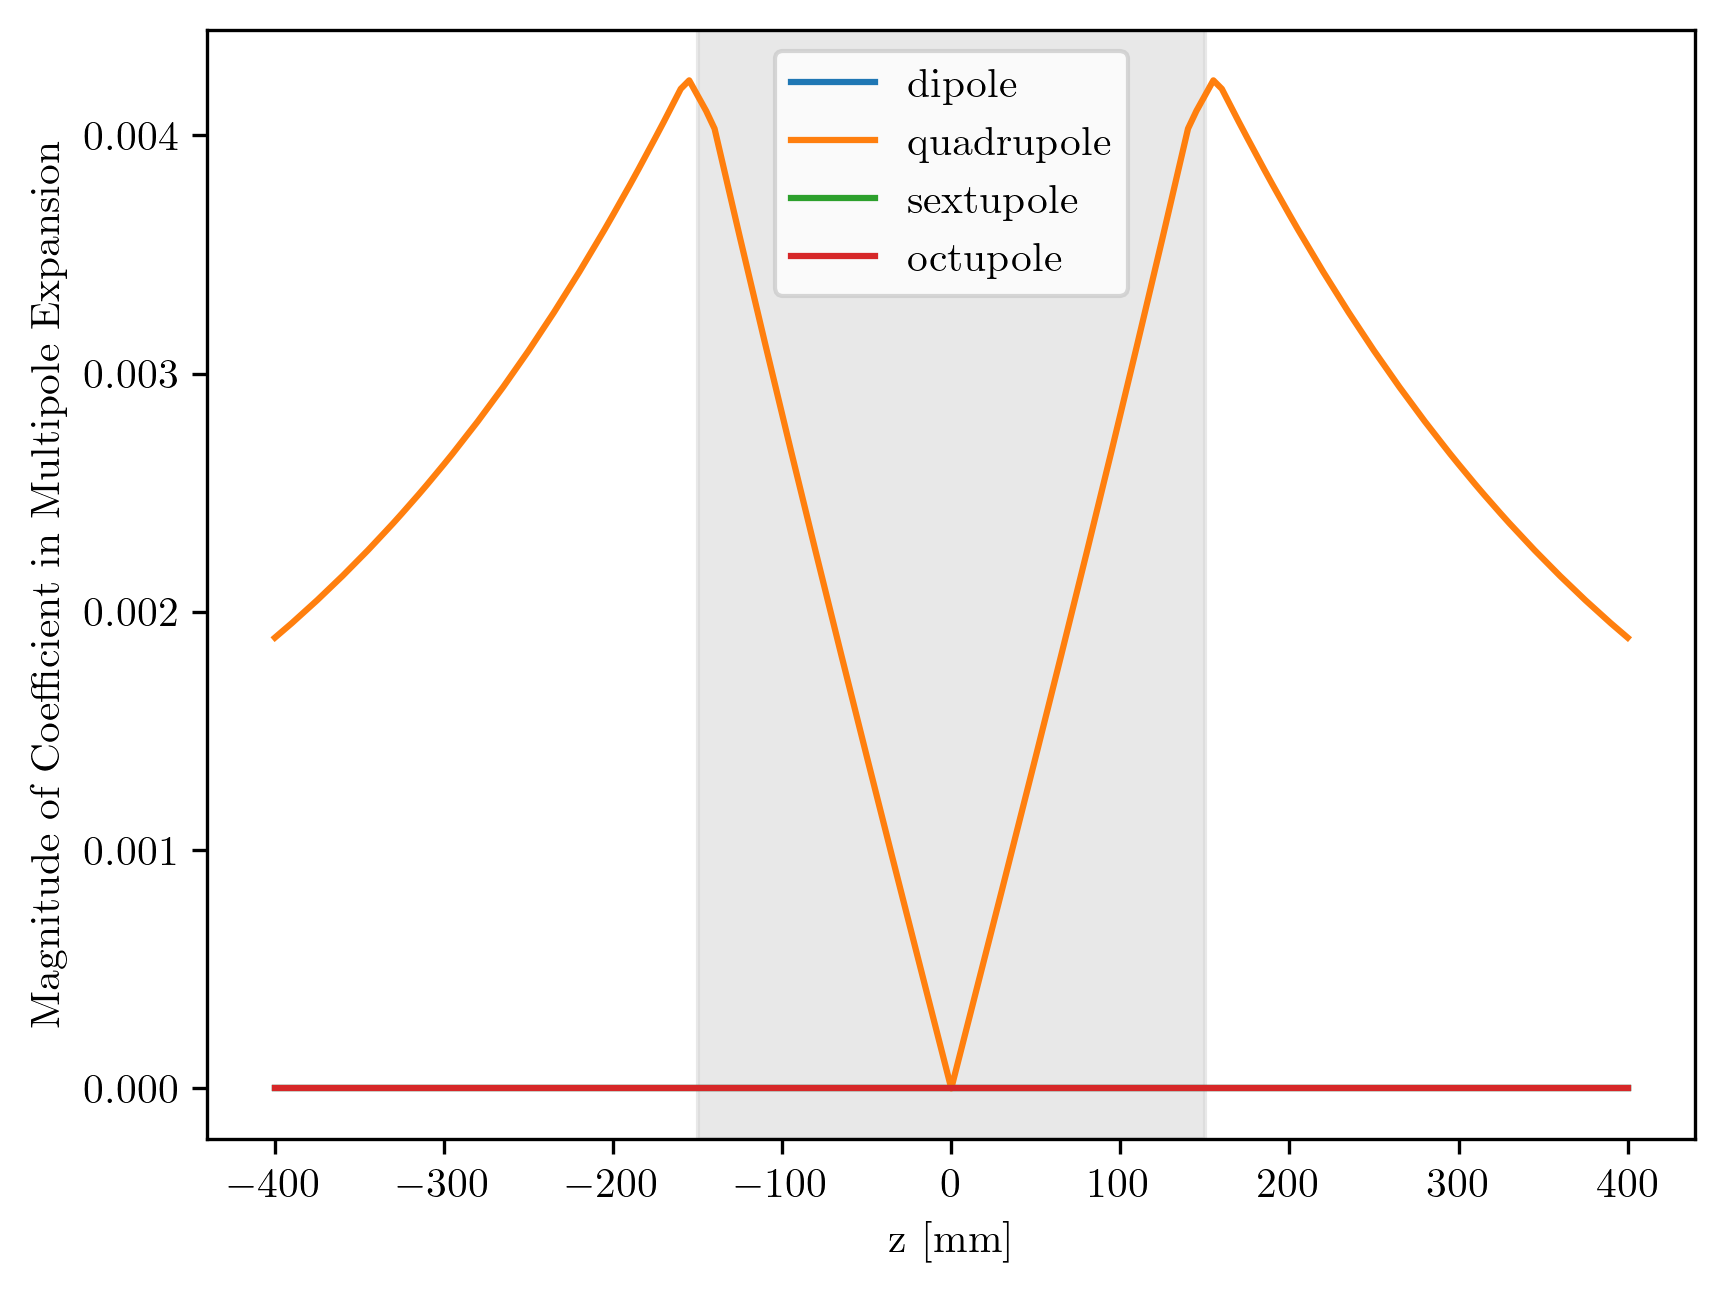

In [8]:
plt.figure()
plt.plot(df['z'], df['n=1'], label='dipole')
plt.plot(df['z'], df['n=2'], label='quadrupole')
plt.plot(df['z'], df['n=3'], label='sextupole')
plt.plot(df['z'], df['n=4'], label='octupole')
plt.legend()
plt.xlabel('z [mm]')
plt.ylabel('Magnitude of Coefficient in Multipole Expansion')
plotLattice()
plt.show()

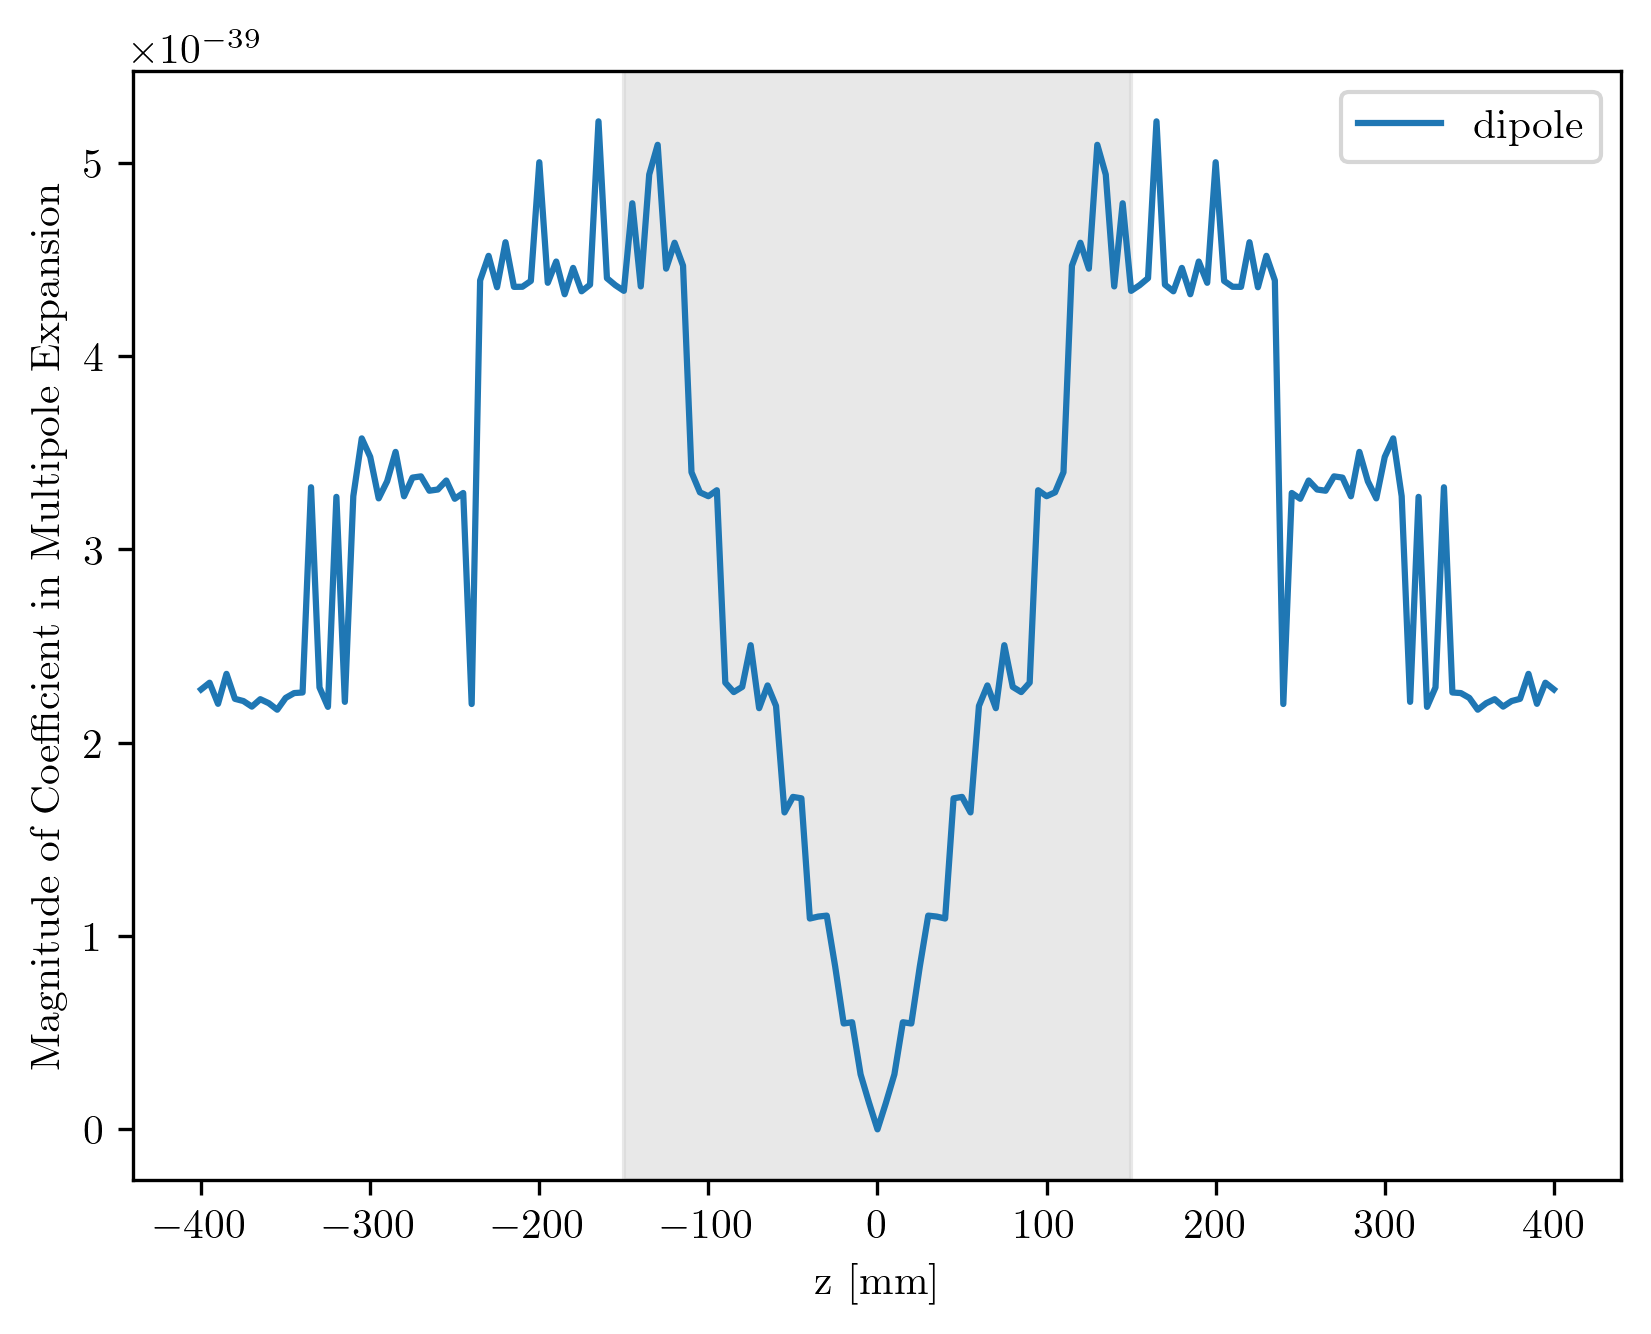

In [9]:
plt.figure()
plt.plot(df['z'], df['n=1'], label='dipole', color='tab:blue')
plt.legend()
plt.xlabel('z [mm]')
plt.ylabel('Magnitude of Coefficient in Multipole Expansion')
plotLattice()
plt.show()

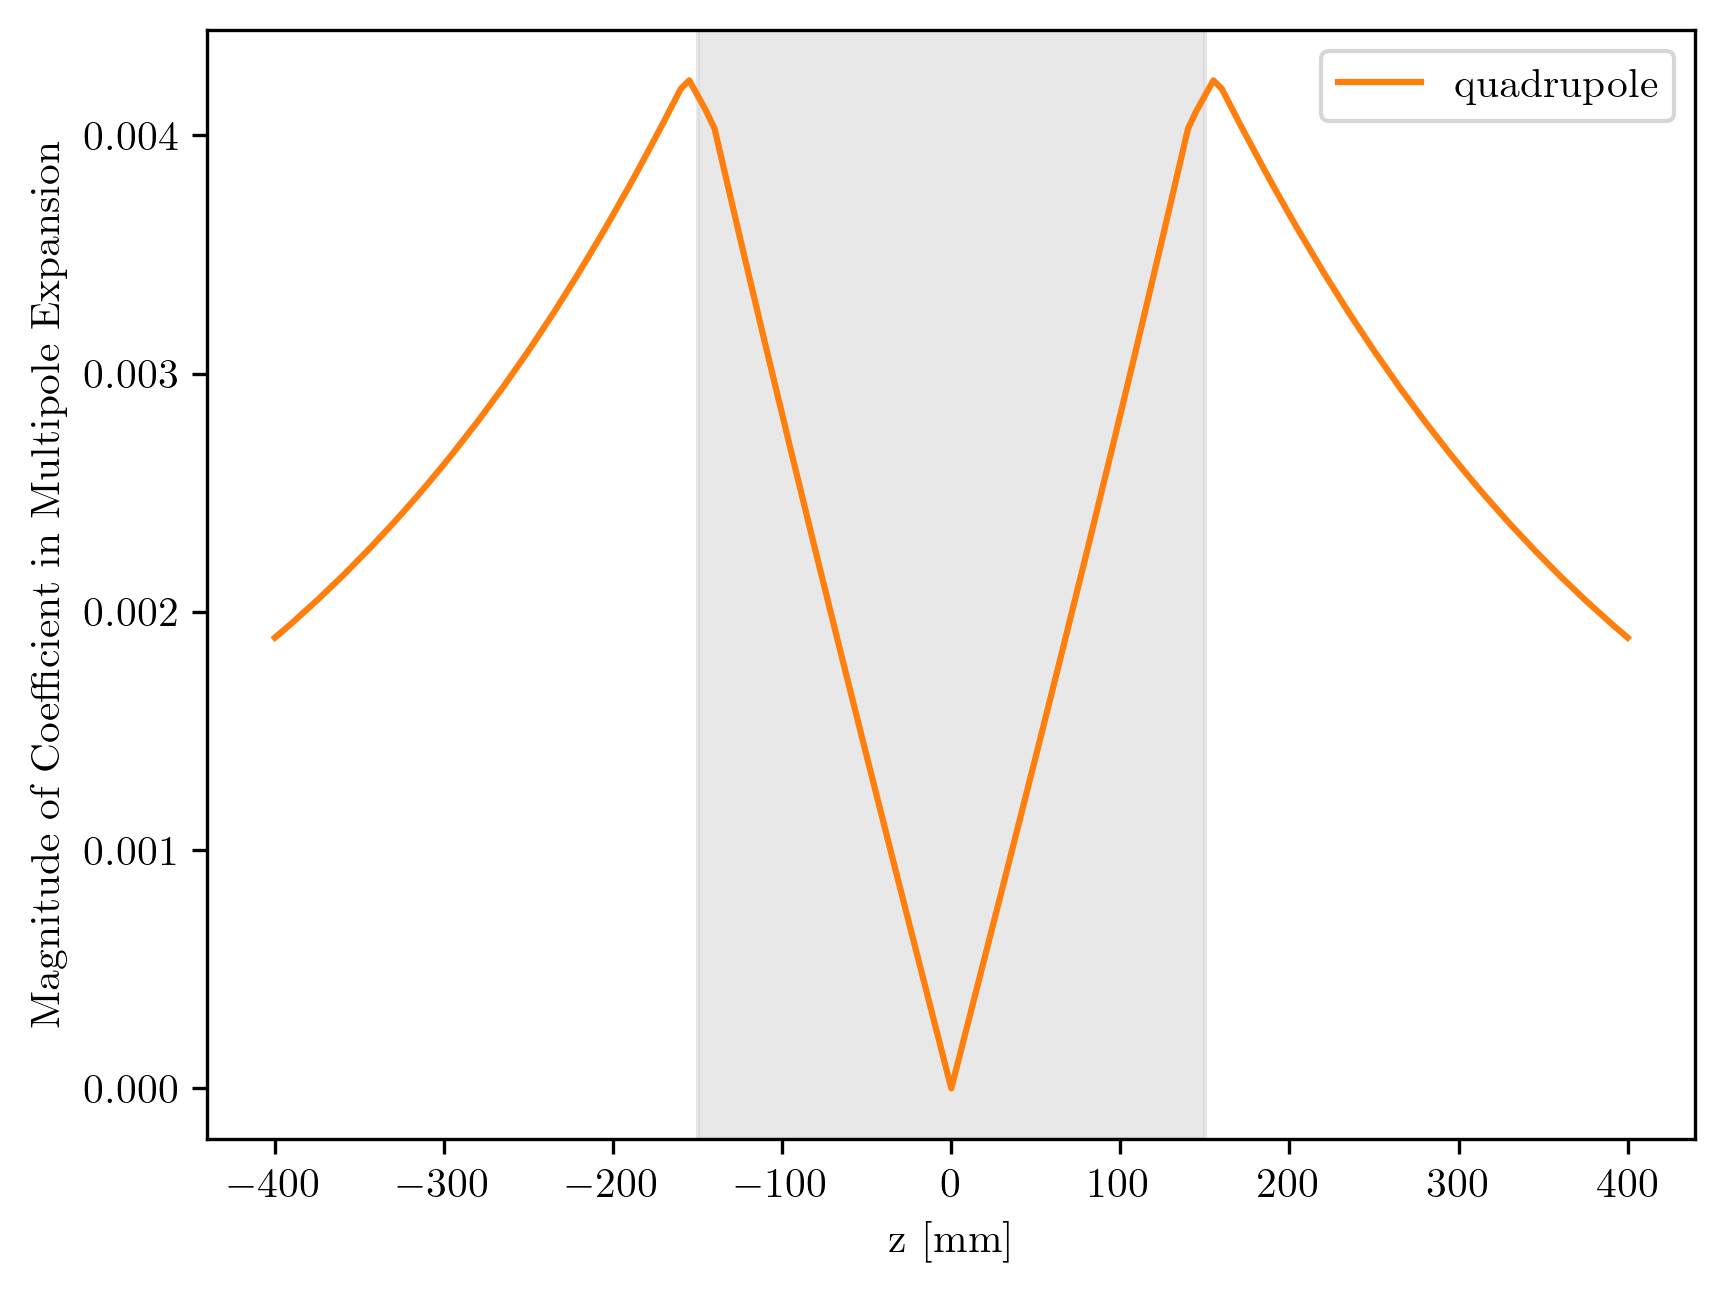

In [10]:
plt.figure()
plt.plot(df['z'], df['n=2'], label='quadrupole', color='tab:orange')
plt.legend()
plt.xlabel('z [mm]')
plt.ylabel('Magnitude of Coefficient in Multipole Expansion')
plotLattice()
plt.show()

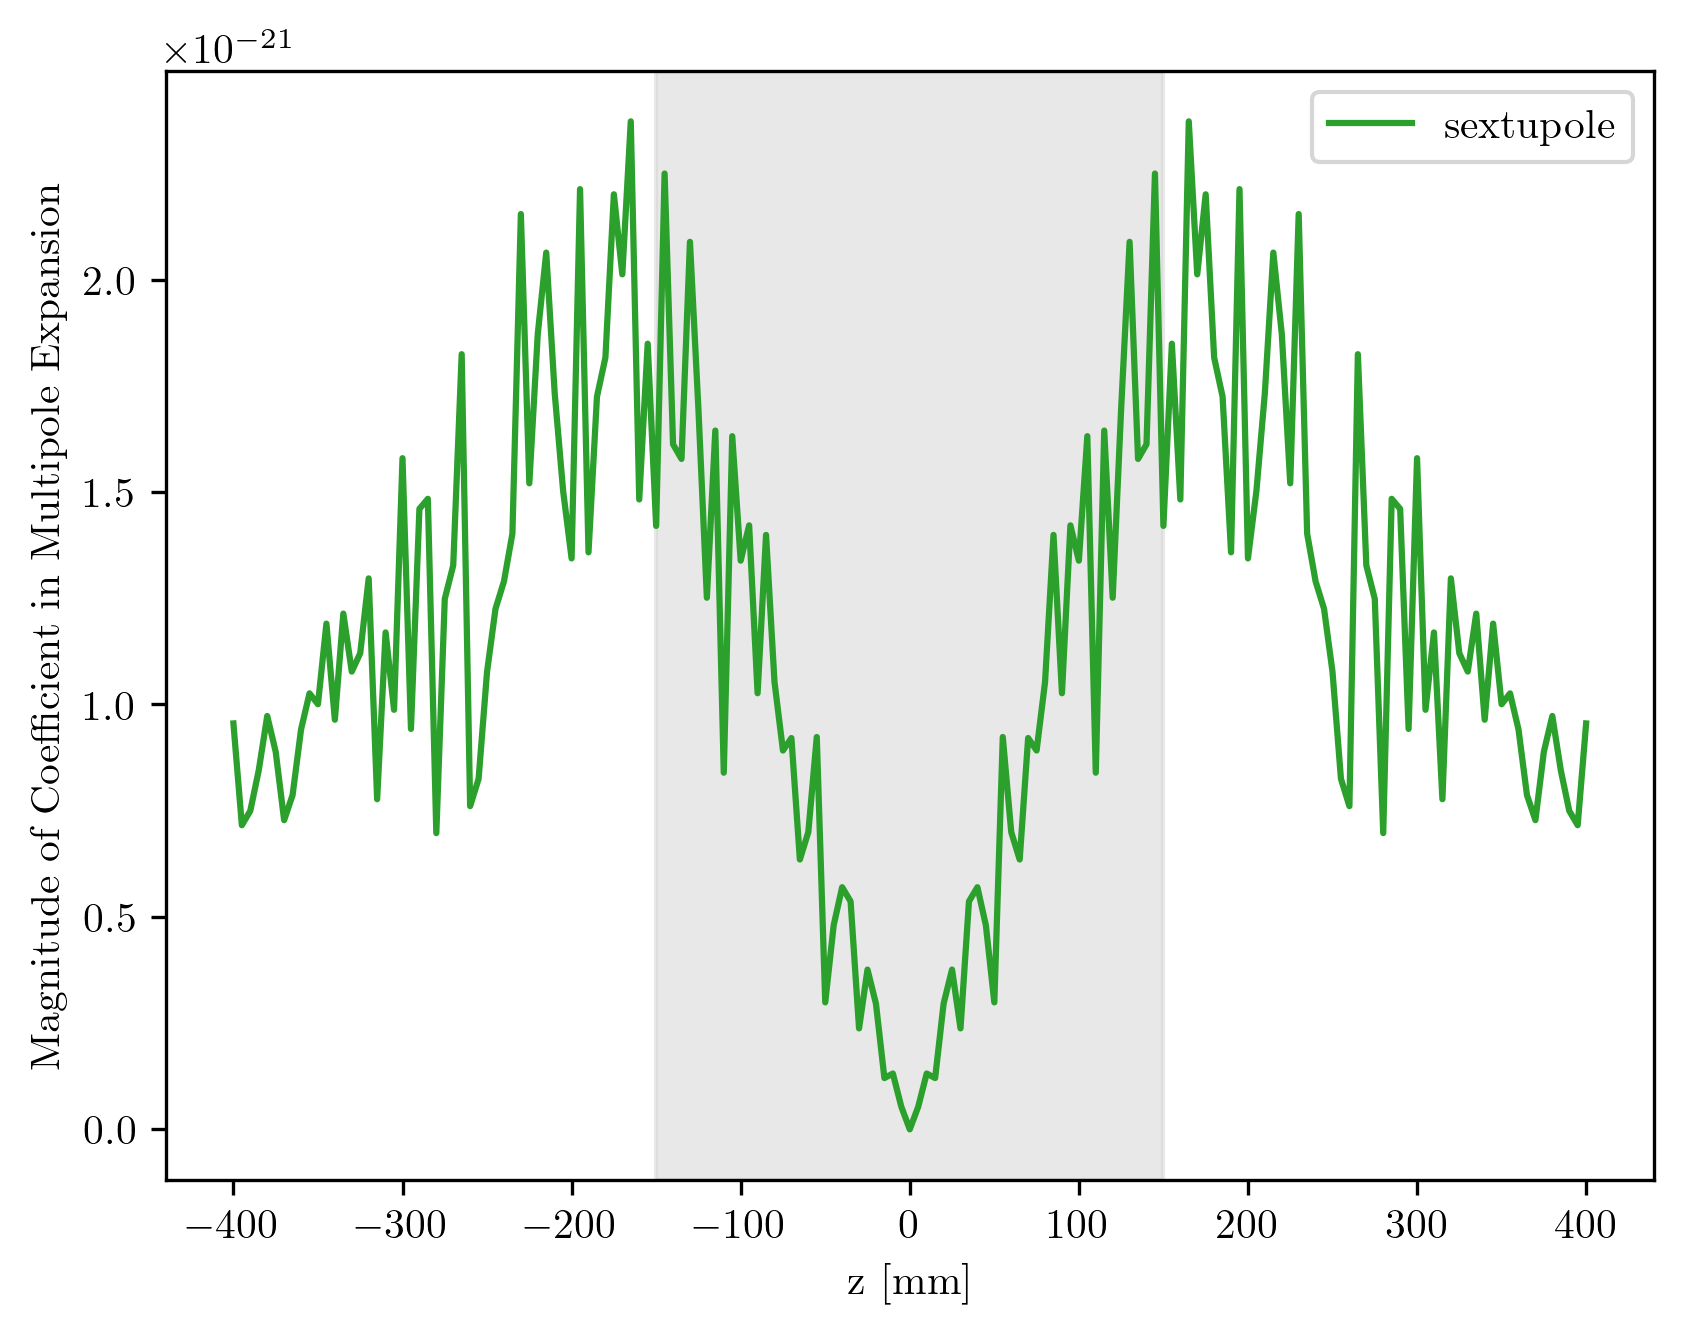

In [11]:
plt.figure()
plt.plot(df['z'], df['n=3'], label='sextupole', color='tab:green')
plt.legend()
plt.xlabel('z [mm]')
plt.ylabel('Magnitude of Coefficient in Multipole Expansion')
plotLattice()
plt.show()

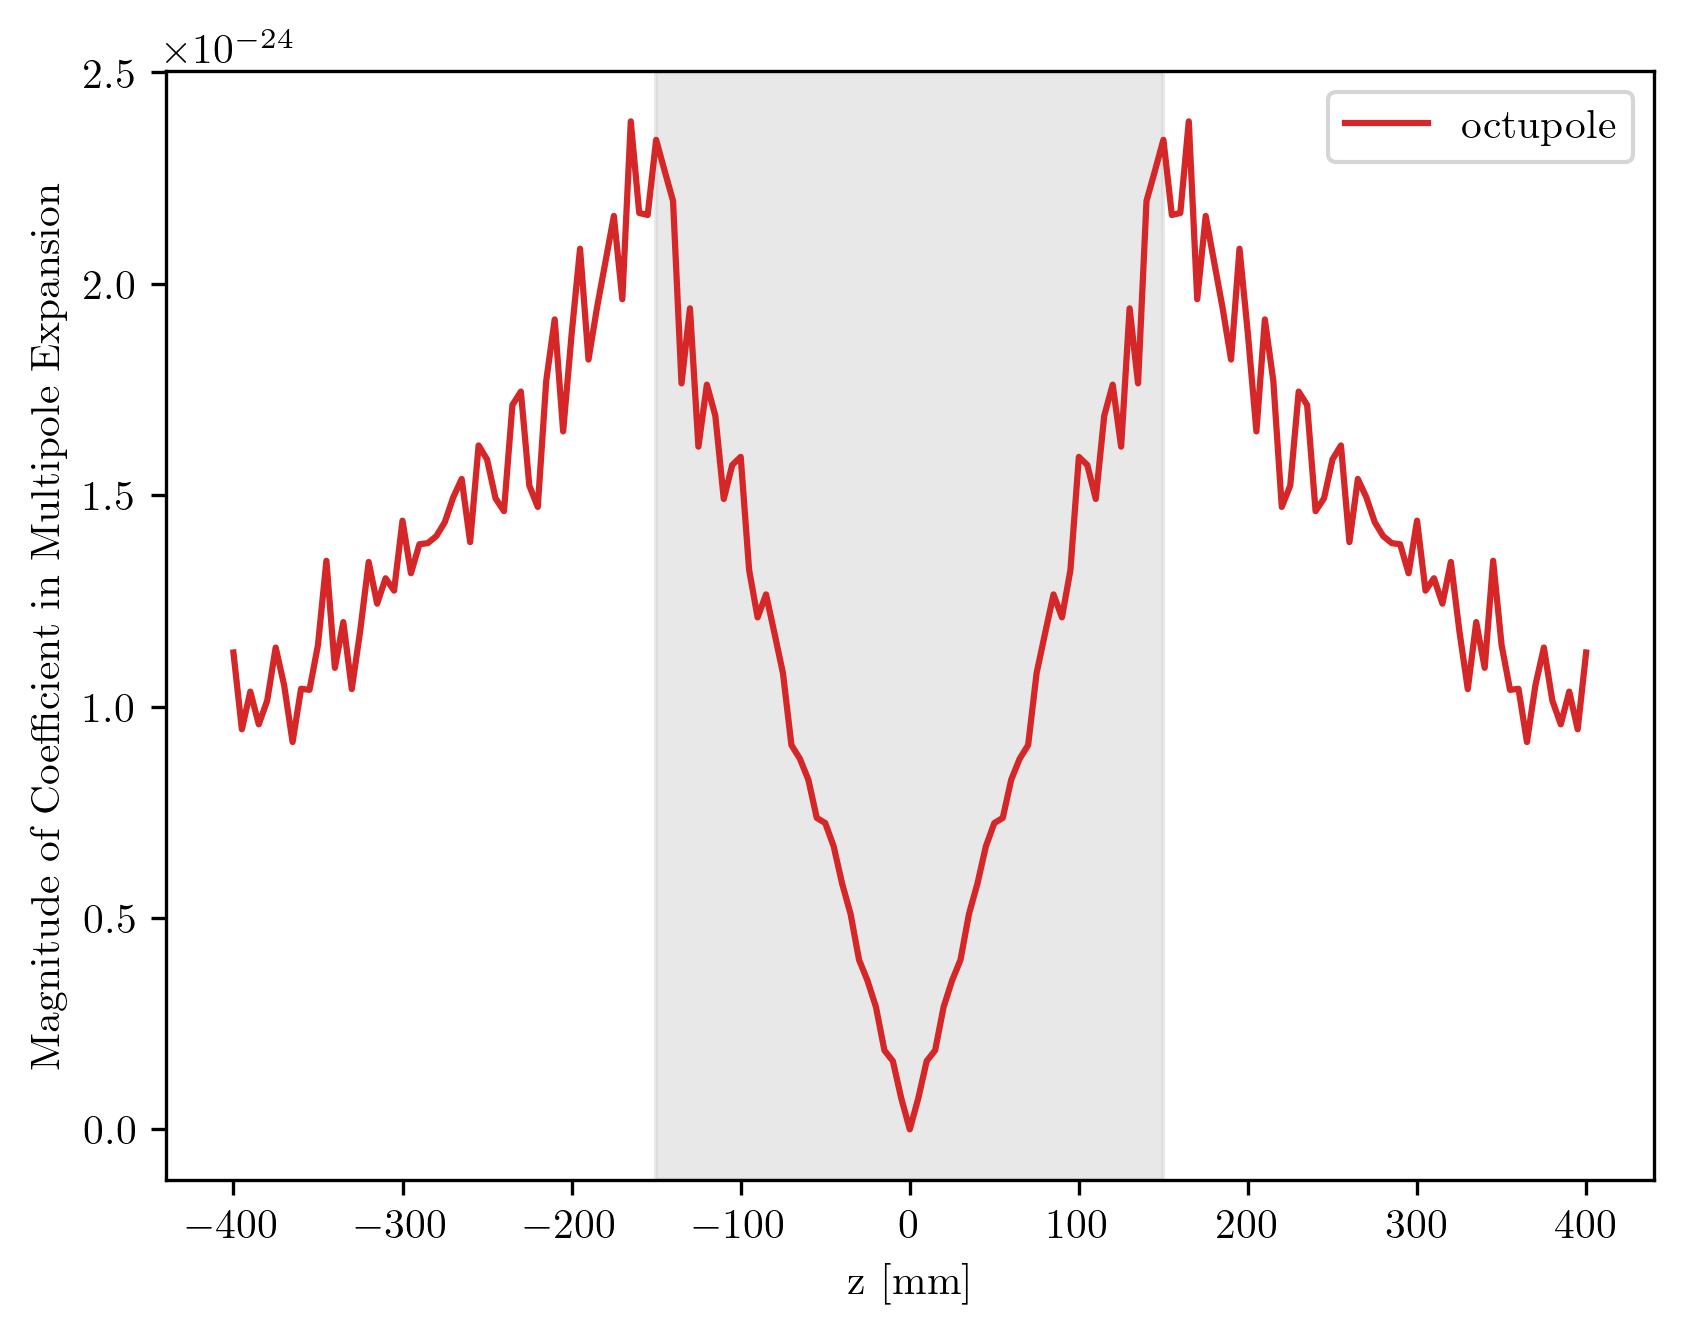

In [12]:
plt.figure()
plt.plot(df['z'], df['n=4'], label='octupole', color='tab:red')
plt.legend()
plt.xlabel('z [mm]')
plt.ylabel('Magnitude of Coefficient in Multipole Expansion')
plotLattice()
plt.show()

### Verify by computing field from multipole coefficients

In [13]:
B_by_z = []
Bx_by_z = []
By_by_z = []
for z in df['z'].values:

        coeff_list = df.loc[np.where(df['z']==z)[0]].values[0][1:]

        B_slice, phi_slice = computeField(x, y, coeff_list)
        Bx_slice = B_slice*np.cos(phi_slice)
        By_slice = B_slice*np.sin(phi_slice)
        B_by_z.append(B_slice)
        Bx_by_z.append(Bx_slice)
        By_by_z.append(By_slice)

MovieWriter ffmpeg unavailable; using Pillow instead.


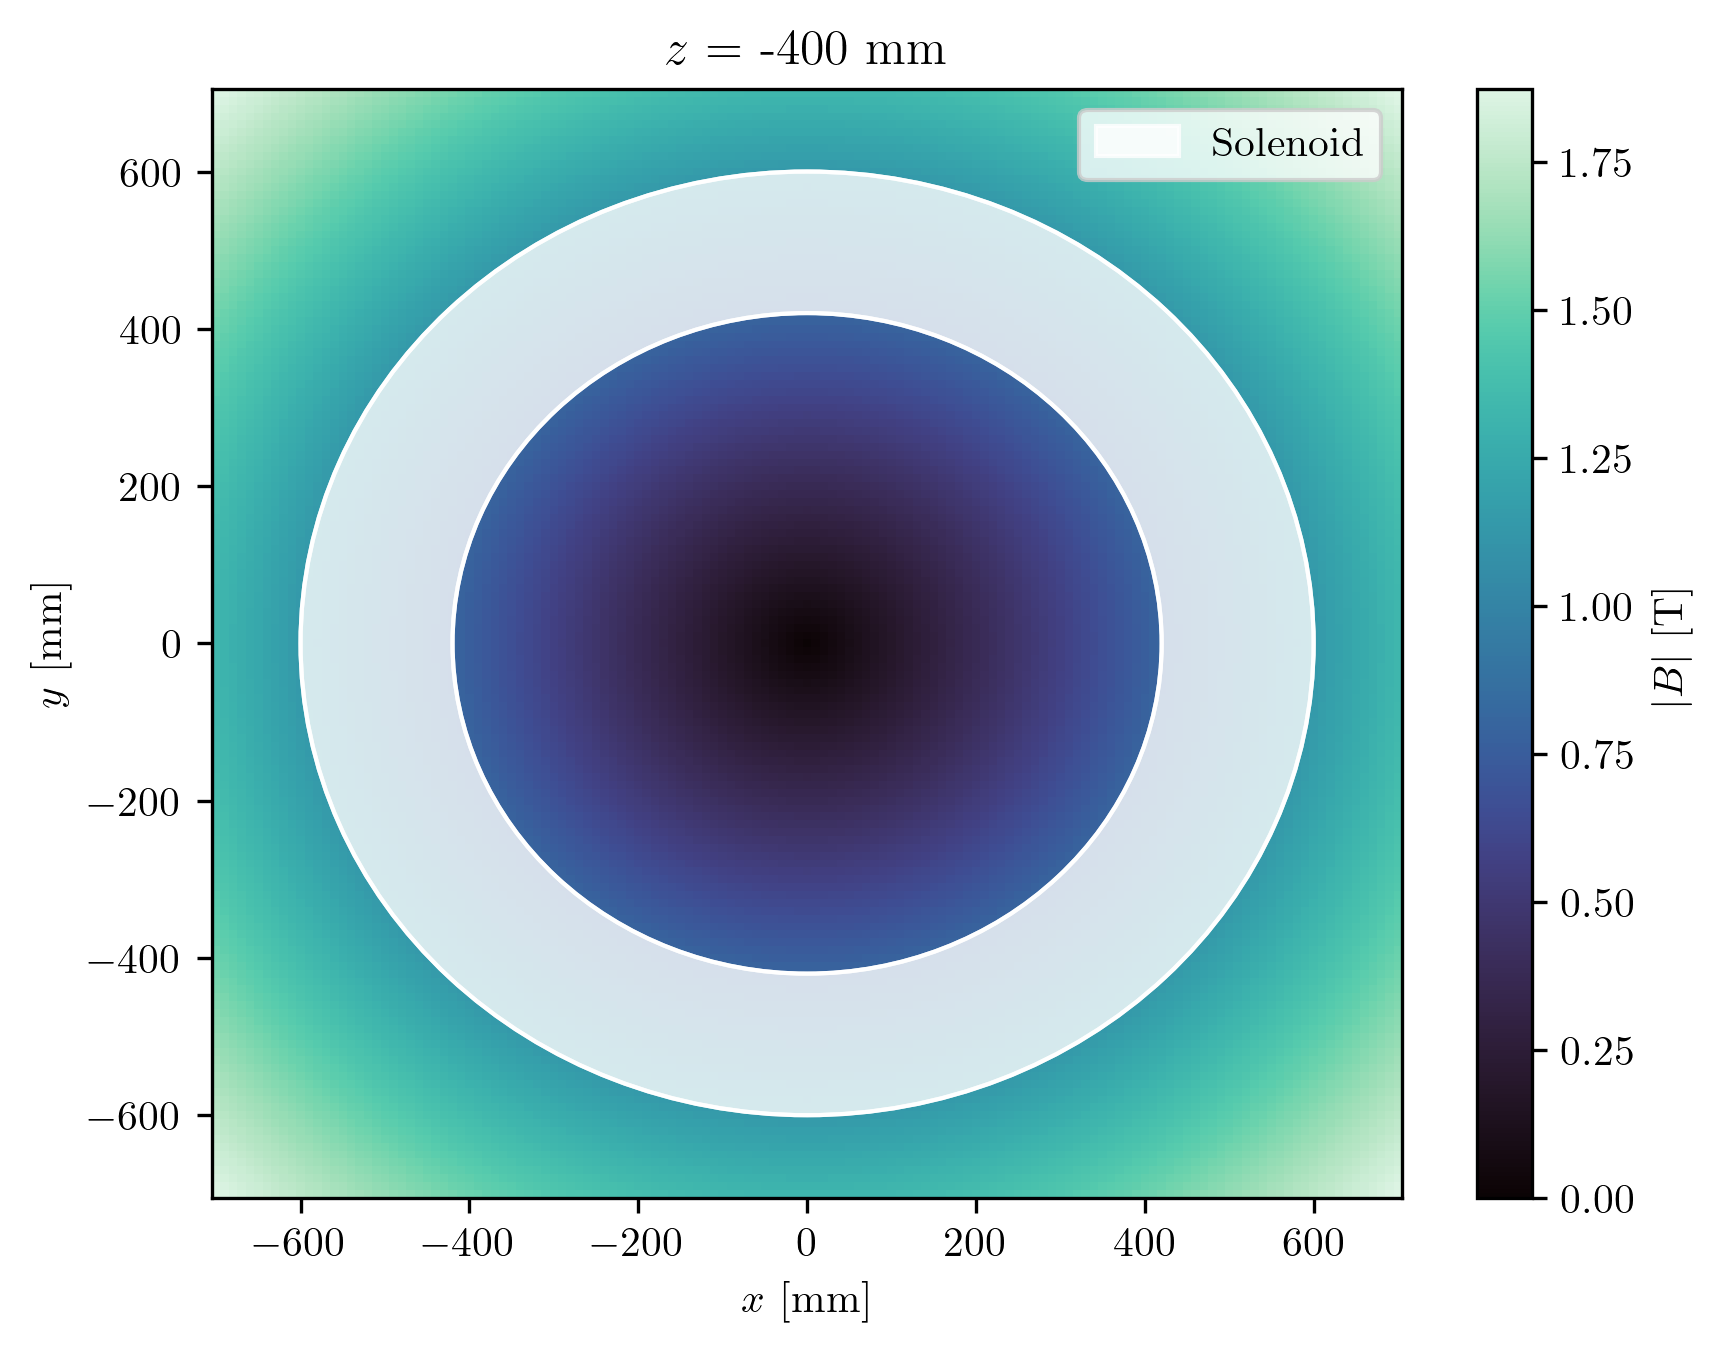

In [14]:
fig, ax = plt.subplots()
cmap = sns.color_palette('mako', as_cmap=True)
pcm = ax.pcolormesh(X, Y, B_by_z[0], cmap=cmap)
plt.colorbar(pcm, ax=ax, label='$|B|$ [T]') # may require some scaling?
plt.xlabel('$x$ [mm]')
plt.ylabel('$y$ [mm]')
plotSolenoid(ax)

def animate(frame):

    ax.set_title(f'$z$ = {df["z"].values[frame]} mm')

    B_grid = B_by_z[frame]
    pcm.set_array(B_grid.ravel())
    return [pcm]

animation = FuncAnimation(fig, animate, frames=len(B_by_z), interval=100, repeat=True)
animation.save(ani_dir+'multipole_expansion.gif')

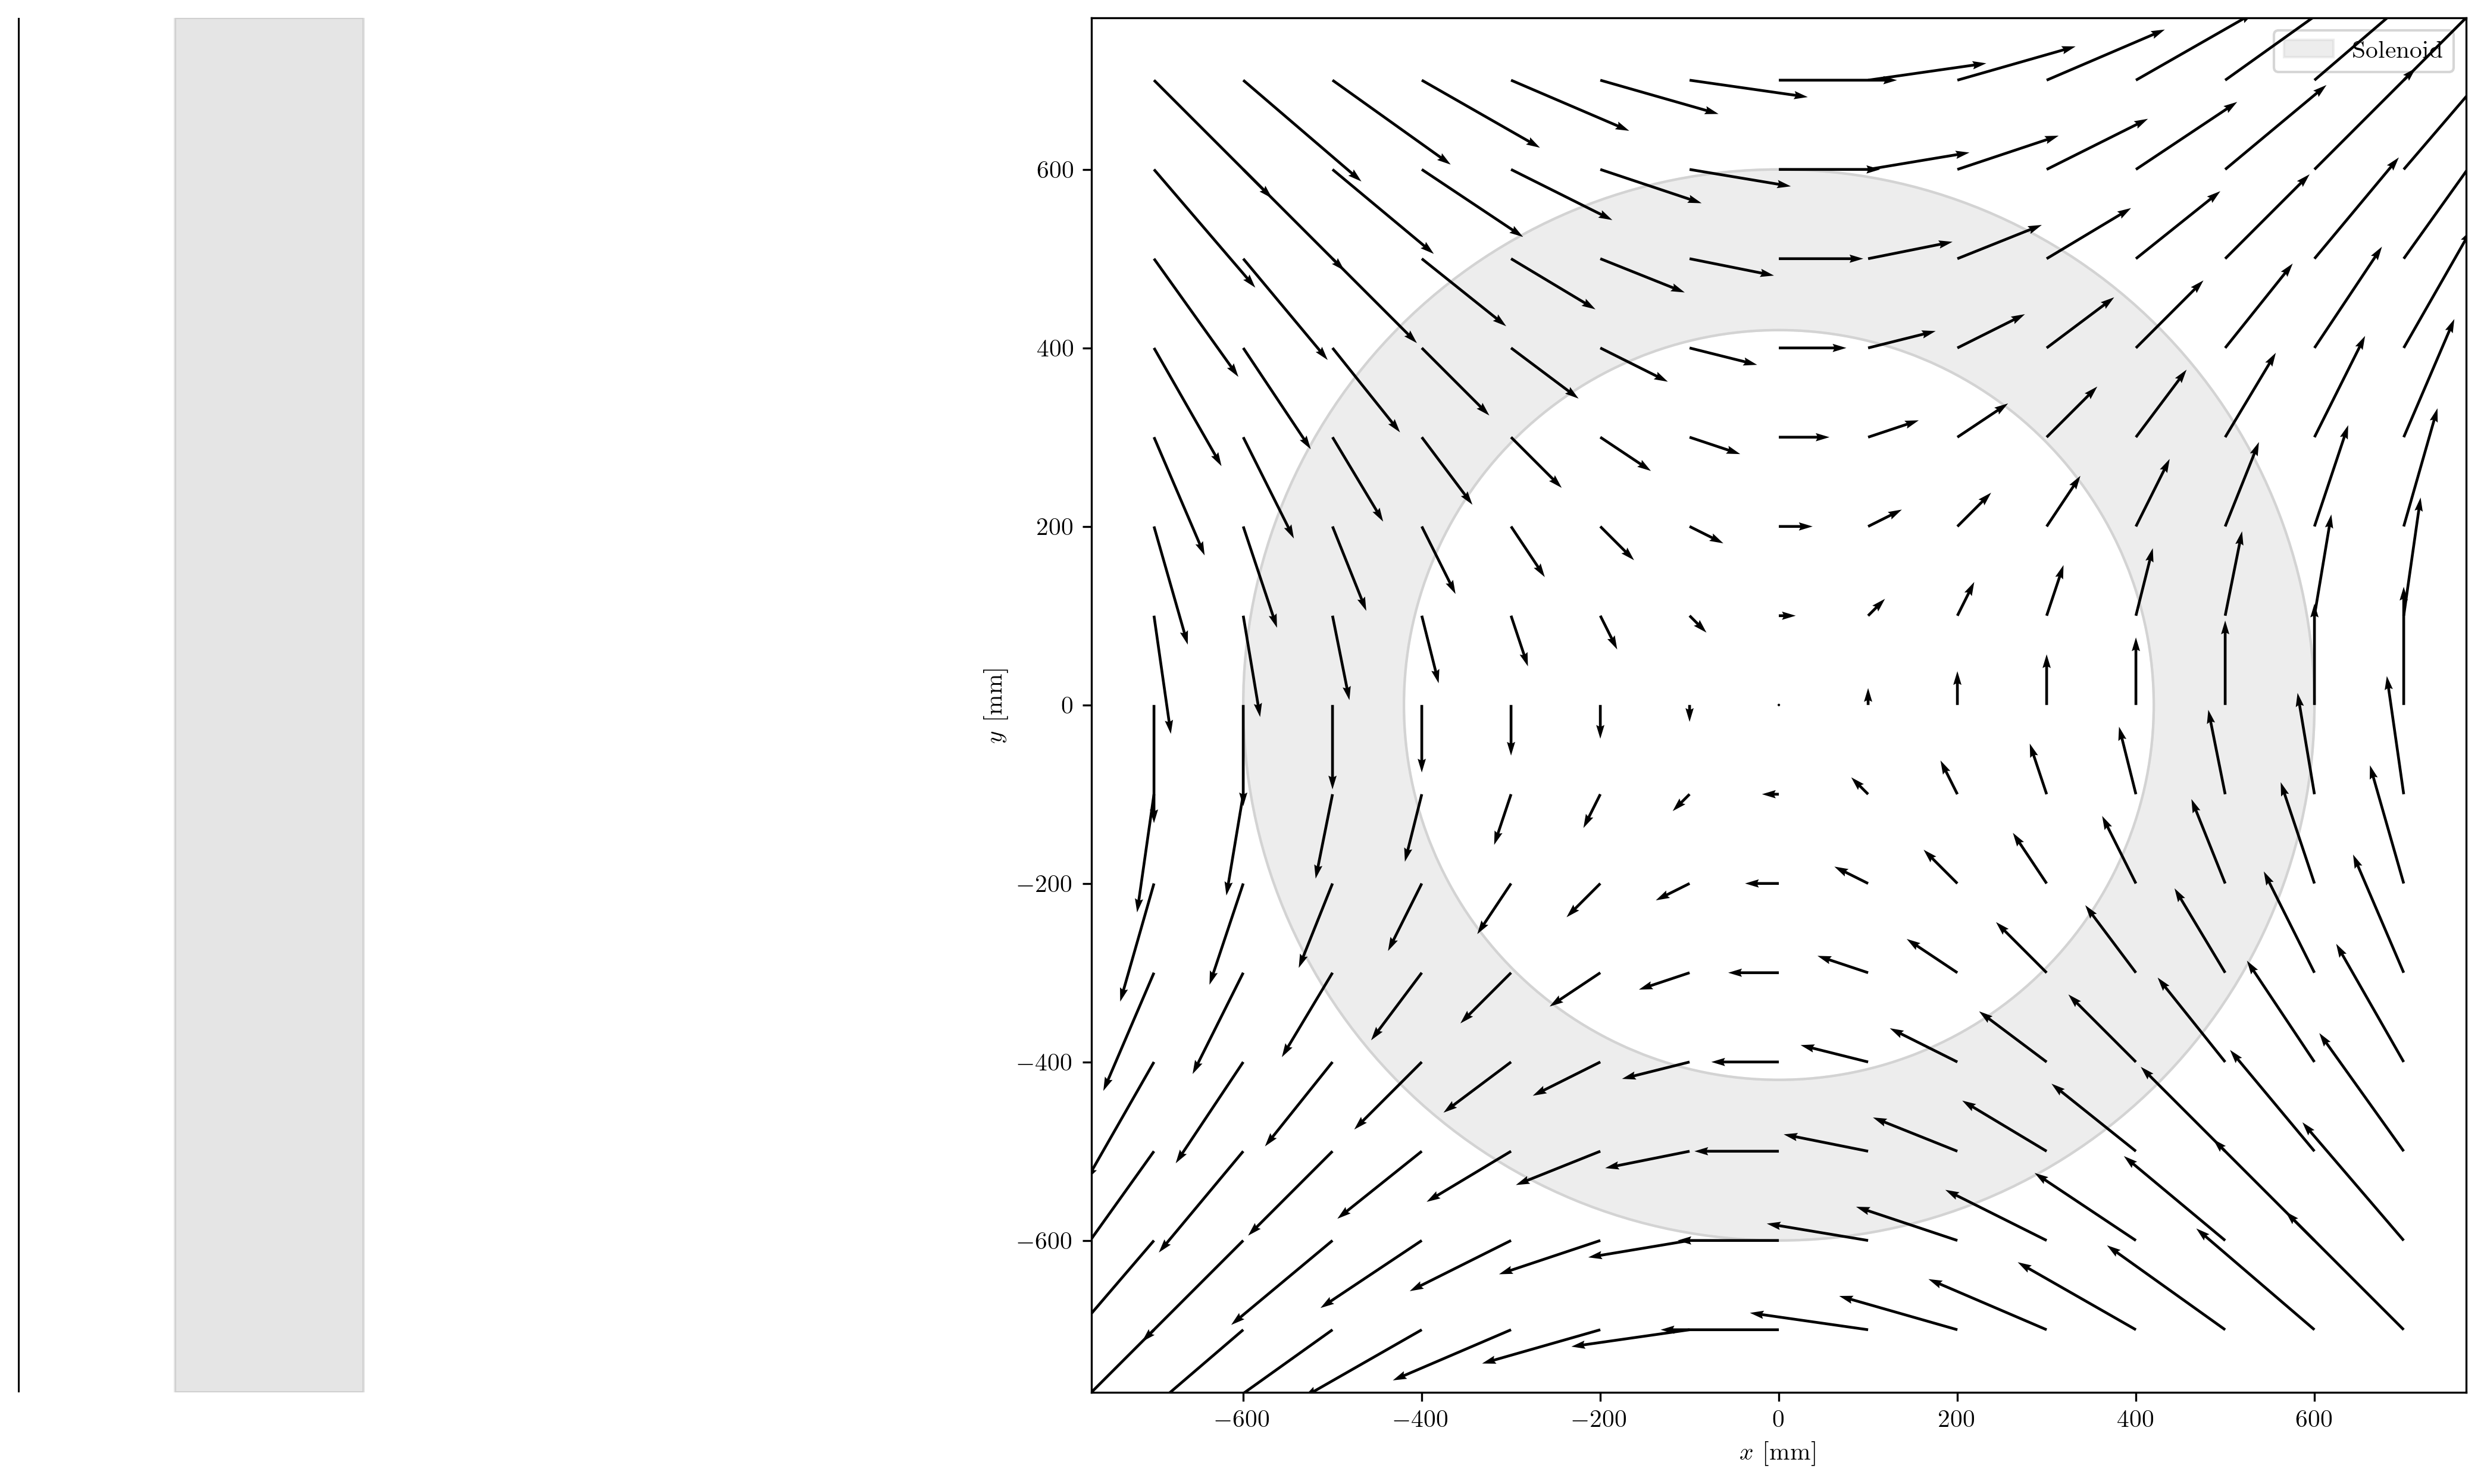

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(20,10), width_ratios=[1,4])
ax, ax2 = axs[1], axs[0]

arrayy = [0, 0]
ax2.set_xlim(-400, 400)
ax2.axvspan(xmin=-150, xmax=150, color='gray', alpha=0.2)
ax2.set_yticks([])
ax2.set_xticks([])
ax2.set_frame_on(False)
vline = ax2.axvline(x=df['z'].values[0], color='black')

ax.set_xlabel('$x$ [mm]')
ax.set_ylabel('$y$ [mm]')
circle_inner = plt.Circle([0,0], radius=a, fill=False, linestyle='-', color='lightgray')
ax.add_patch(circle_inner)
circle_outer = plt.Circle([0,0], radius=b, fill=False, linestyle='-', color='lightgray')
ax.add_patch(circle_outer)
fill = Wedge(center=(0, 0), r=b, theta1=0, theta2=360, width=b - a, color='lightgray', label='Solenoid', alpha=0.4)
ax.add_patch(fill)
plt.legend(loc='upper right')
ax.set_aspect('equal')

quiver_plot = None

step = 10

def animate(frame):
    global quiver_plot

    z_val = df['z'].values[frame]
    vline.set_xdata([z_val])

    Bx_grid = Bx_by_z[frame]
    By_grid = By_by_z[frame]
    B_grid = B_by_z[frame]

    X_ds = X[::step, ::step]
    Y_ds = Y[::step, ::step]
    Bx_ds = Bx_grid[::step, ::step]
    By_ds = By_grid[::step, ::step]

    pcm.set_array(B_grid.ravel())

    if quiver_plot:
        quiver_plot.remove()

    quiver_plot = ax.quiver(
        X_ds, Y_ds, Bx_ds, By_ds,
        color='black',
        angles="xy", scale_units="xy", scale=0.01,
        width=0.002, zorder=10
    )

    return [pcm, vline, quiver_plot]

animation = FuncAnimation(fig, animate, frames=len(df['z'].values), interval=100, blit=False, repeat=False)
animation.save(ani_dir+'multipole_expansion_quiver.gif', writer='pillow')